Download modules

In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install pillow
!pip -q install transformers==4.10.0
!pip -q install sentencepiece==0.1.94
!pip -q install datasets
!pip install happytransformer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

Convert image to readable format

In [ ]:
import numpy as np
import cv2
import pytesseract as pt
import pandas as pd
import torch
import os
import time
import copy
import matplotlib

from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration
from transformers import AdamW, WarmUp, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from happytransformer import HappyTextToText, TTSettings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img=cv2.imread('/content/drive/MyDrive/IT350_dataset/Test_image/image2.png')[10:650]
print(img.shape[0],img.shape[1])
y=int(img.shape[0]/32)*32
x=int(img.shape[1]/32)*32
img=cv2.resize(img,(x,y))
print(img.shape[0],img.shape[1])
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

464 1152
448 1152


In [ ]:
dpi = matplotlib.rcParams['figure.dpi']
figsize=img.shape[1]/dpi,img.shape[0]/dpi

In [ ]:
def decode_predictions(scores, geometry,minConfidence):
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
 
	for y in range(0, numRows):
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
 
		for x in range(0, numCols):
			if scoresData[x] < minConfidence:
				continue
 
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
 
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
 
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
 
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
 
	return (rects, confidences)

In [ ]:
def returnContours(mask):
    cnts=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    rects=[cv2.boundingRect(cnt) for cnt in cnts]
    rects=np.array([[x,y,x+w,y+h] for x,y,w,h in rects])
    return rects

In [ ]:
def drawRects(rects,img):
    for x1,y1,x2,y2 in rects:
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
    

In [ ]:
meanRGB=(123.68, 116.78, 103.94)
h,w=img.shape[:2]
blob=cv2.dnn.blobFromImage(img,1.0,(w,h),meanRGB,swapRB=True,crop=False)

layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
net=cv2.dnn.readNet('/content/drive/MyDrive/IT350_dataset/Test_image/frozen_east_text_detection.pb')

net.setInput(blob)
scores,locs=net.forward(layerNames)

rects,conf=decode_predictions(scores,locs,0.3)
rects=non_max_suppression(np.array(rects), probs=conf)

In [ ]:
black=np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
mask=black.copy()
for x1,y1,x2,y2 in rects:
    mask[max(0,y1):min(mask.shape[0],y2),max(0,x1):min(mask.shape[1],x2)]=255


In [ ]:
discard=np.where(rects<0)
print(discard)
rects=np.delete(rects,discard,axis=0)

(array([], dtype=int64), array([], dtype=int64))


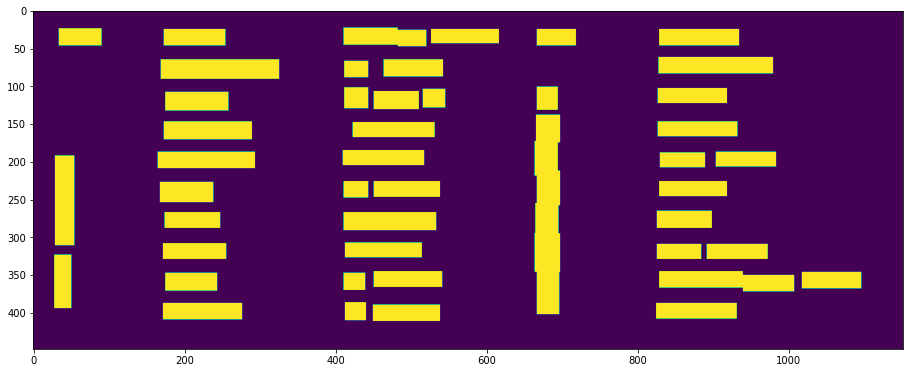

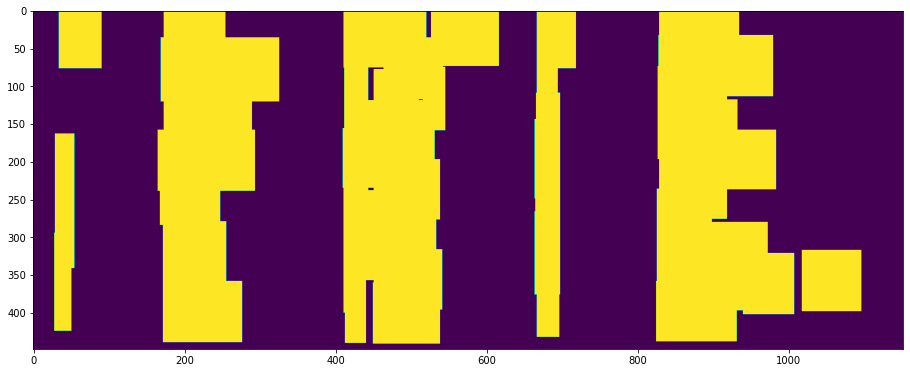

In [ ]:
kernel=np.ones((60,1),np.uint8)
mask2=cv2.dilate(mask.copy(),kernel)


fig=plt.figure(figsize=figsize)
plt.imshow(mask)
fig=plt.figure(figsize=figsize)
plt.imshow(mask2)


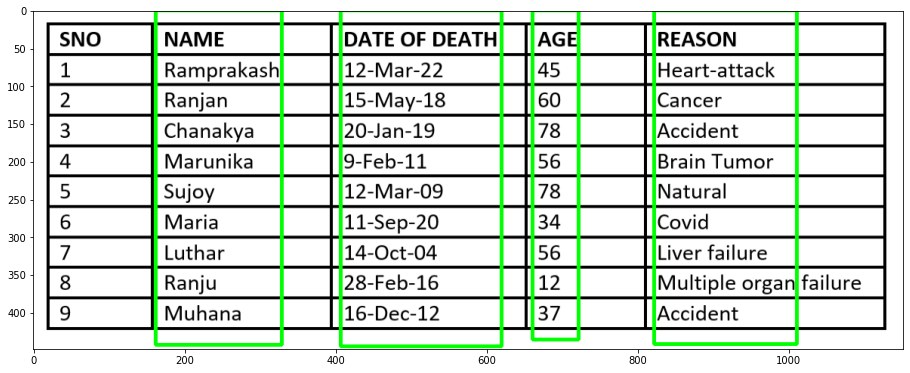

In [ ]:
batches=returnContours(mask2)
batches=np.array([[max(0,x1-3),max(0,y1-2),min(img.shape[1],x2+3),min(img.shape[0],y2+3)] for x1,y1,x2,y2 in batches if y1<img.shape[0]/5])
batches=batches[np.argsort(batches[:,0])][1:]

batchBox=img.copy()
drawRects(batches,batchBox)
fig=plt.figure(figsize=figsize)
plt.imshow(batchBox)

Read image using OCR

In [ ]:
import pytesseract
import shutil
import os
import random
from PIL import Image

In [ ]:
config='--psm 6'

texts=[]
for x1,y1,x2,y2 in batches:
    crop = img[y1:y2,x1:x2].copy()
    crop = cv2.GaussianBlur(crop,(3,3),0)
    temp_text = pt.image_to_string(crop,lang='eng',config=config)
    texts.append([txt for txt in temp_text.split('\n') if txt!=''])

max_info = max([len(i) for i in texts])
text = []
for i in range(0,len(texts)):
    try:
      x = int(texts[i][0])
      x = float(texts[i][0])
      texts[i].insert(0,"Number")
      text.append(texts[i])
    except ValueError:
      text.append(texts[i])

for i in text:
  print(i)




['NAME', 'Ramprakash', 'Ranjan', 'Chanakya', 'Marunika', 'Sujoy', 'Maria', 'Luthar', 'Ranju', 'Muhana', '\x0c']
['DATE OF DEATH', '12-Mar-22', '15-May-18', '20-Jan-19', '9-Feb-11', '12-Mar-09', '11-Sep-20', '14-Oct-04', '28-Feb-16', '16-Dec-12', '\x0c']
['AGE', 'a5', '60', '78', '56', '78', '2', '56', '12', 'a7', '\x0c']
['REASON', 'Heart-attack', 'Cancer', 'Accident', 'Brain Tumor', 'Natural', 'Covid', 'Liver failure', 'Multiple organ', 'Accident', '\x0c']


In [ ]:
#Identify headings and data. Convert to dataframe and save to excel file
keys=[lis[0] for lis in texts]
keys
data={}
for i,key in enumerate(keys):
    data[key]=text[i][1:]

df=pd.DataFrame({k : pd.Series(v) for k, v in data.items()})
df.index=np.arange(1,len(df)+1)
df.to_csv('/content/drive/MyDrive/IT350_dataset/Test_image/table.csv')
df

,NAME,DATE OF DEATH,AGE,REASON
1,Ramprakash,12-Mar-22,a5,Heart-attack
2,Ranjan,15-May-18,60,Cancer
3,Chanakya,20-Jan-19,78,Accident
4,Marunika,9-Feb-11,56,Brain Tumor
5,Sujoy,12-Mar-09,78,Natural
6,Maria,11-Sep-20,2,Covid
7,Luthar,14-Oct-04,56,Liver failure
8,Ranju,28-Feb-16,12,Multiple organ
9,Muhana,16-Dec-12,a7,Accident
10,,,,


Convert table to structured dataset format

In [ ]:
title = ""
section = ""
n = len(text)
structured_table = []
max_info = max([len(i) for i in texts])

for j in range(1,max_info-1):
  table_format = "<page_title>"+title+"</page_title>"+"<section_title>"+section+"</section_title>"+"<table>"
  for i in range(0,n):
    table_format = table_format + "<cell>" + text[i][j] + "<col_header>" + text[i][0] + "</col_header></cell>"
  structured_table.append([table_format + "</table>",""])

df = pd.DataFrame(structured_table,columns=['table','sentence'])
print(df)

                                               table sentence
0  <page_title></page_title><section_title></sect...         
1  <page_title></page_title><section_title></sect...         
2  <page_title></page_title><section_title></sect...         
3  <page_title></page_title><section_title></sect...         
4  <page_title></page_title><section_title></sect...         
5  <page_title></page_title><section_title></sect...         
6  <page_title></page_title><section_title></sect...         
7  <page_title></page_title><section_title></sect...         
8  <page_title></page_title><section_title></sect...         


Convert structured dataset format to sentence using T5

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model=torch.load("/content/drive/MyDrive/IT350_dataset/T5model_epoch_7", map_location=device)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

In [ ]:
special_tokens_dict = {'pad_token': '<pad>', 'bos_token': '<bos>', 'eos_token': '<eos>', 
                       'additional_special_tokens': ['<PAGESTART>', '<PAGEEND>', '<SECTIONSTART>', '<SECTIONEND>',
                                                     '<TABLESTART>','<TABLEEND>','<CELLSTART>','<CELLEND>','<COLHEADERSTART>',
                                                     '<COLHEADEREND>','<ROWHEADERSTART>','<ROWHEADEREND>']}

num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

print('We have added', num_added_toks, 'tokens')
model.encoder.resize_token_embeddings(len(tokenizer))
model.decoder.resize_token_embeddings(len(tokenizer))

We have added 14 tokens


Embedding(32114, 768)

In [ ]:
MAXLENI=400
MAXLENO=200

class tottodataset(Dataset):
  def __init__(self,df,tokenizer):
    self.sentence=df['sentence']
    self.table=df['table']
    self.tokenizer=tokenizer

  def __len__(self):
    return len(self.sentence)
  
  def __getitem__(self,idx):
    inp=(self.table[idx]+'</s>').replace("<page_title>", "<PAGESTART>").replace("</page_title>", "<PAGEEND>") \
                                    .replace("<section_title>", "<SECTIONSTART>").replace("</section_title>", "<SECTIONEND>") \
                                    .replace("<table>", "<TABLESTART>").replace("</table>", "<TABLEEND>") \
                                    .replace("<cell>", "<CELLSTART>").replace("</cell>", "<CELLEND>") \
                                    .replace("<col_header>", "<COLHEADERSTART>").replace("</col_header>", "<COLHEADEREND>") \
                                    .replace("<row_header>", "<ROWHEADERSTART>").replace("</row_header>", "<ROWHEADEREND>")
    out=self.sentence[idx]+'</s>'
    inp_tokens=self.tokenizer.encode_plus(inp, padding="max_length", max_length=MAXLENI, truncation=True)
    out_tokens=self.tokenizer.encode_plus(out, padding="max_length", max_length=MAXLENO, truncation=True)
    inp_id=inp_tokens.input_ids
    out_id=out_tokens.input_ids
    inp_mask=inp_tokens.attention_mask
    out_mask=out_tokens.attention_mask
    labels=out_tokens.input_ids.copy()
    labels=[-100  if x==self.tokenizer.pad_token_id else x for x in labels]

    return {
        "table_text":inp,
        "sentence":out,
        "input_ids":torch.tensor(inp_id, dtype=torch.long),
        "input_attention_mask":torch.tensor(inp_mask, dtype=torch.long),
        "decoder_input_ids":torch.tensor(out_id, dtype=torch.long),
        "decoder_attention_mask":torch.tensor(out_mask, dtype=torch.long),
        "labels":torch.tensor(labels, dtype=torch.long)
    }

In [ ]:
test_dataset=tottodataset(df,tokenizer)
#test_dataloader=DataLoader(test_dataset,batch_size=64,num_workers=2,shuffle=False)
test_dataloader=DataLoader(test_dataset)
print(len(test_dataset))
print(len(test_dataloader))

9
9


In [ ]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32114, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
def grammer_corrector(input_text):

    happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")
    args = TTSettings(num_beams=5, min_length=1)
    input1 = "grammer: " + input_text
    result = happy_tt.generate_text(input1, args=args)
    return result.text

In [ ]:
test_iterator = iter(test_dataloader)
for i in range(0,len(test_dataset)):
  test_batch = next(test_iterator)
  generation_output = model.generate(test_batch['input_ids'].to(device), return_dict_in_generate=True, output_scores=True)
  print(grammer_corrector(tokenizer.decode(generation_output["sequences"][0],skip_special_tokens=True)),end="\n\n")

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

04/25/2022 21:12:17 - INFO - happytransformer.happy_transformer -   Using model: cpu


Ramprakash (a5 years old) died on 12 March 22 at age 62.



04/25/2022 21:12:29 - INFO - happytransformer.happy_transformer -   Using model: cpu


Ranjan, 60, was diagnosed with cancer on 15 May 18 and died on 15 May 18 .



04/25/2022 21:12:40 - INFO - happytransformer.happy_transformer -   Using model: cpu


Chanakya Chanakya (78), 78, died in Jan 19 after a long illness.



04/25/2022 21:12:52 - INFO - happytransformer.happy_transformer -   Using model: cpu


Marunika (born 9 February 2001) was 56 years old and had a brain tumor.



04/25/2022 21:13:02 - INFO - happytransformer.happy_transformer -   Using model: cpu


Sujoy (78), born 12-Mar-09, was a natural born child of the family.



04/25/2022 21:13:14 - INFO - happytransformer.happy_transformer -   Using model: cpu


Maria (11 Sep-20), a second-year-old from Covid, was the grammer.



04/25/2022 21:13:25 - INFO - happytransformer.happy_transformer -   Using model: cpu


Luthar Luthar (14 October 2004 – 14 October 2004) was 56 years old.



04/25/2022 21:13:38 - INFO - happytransformer.happy_transformer -   Using model: cpu


Ranju Ranju (28 February 2016 – 12 February 1996) was a 12-year-old.



04/25/2022 21:13:51 - INFO - happytransformer.happy_transformer -   Using model: cpu


Muhana (16 December 12 – 16 December ) was an a7-year-old.

